<a href="https://colab.research.google.com/github/Talha1902/Visual-Intelligence-Project/blob/main/VSPRoject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
# Install required packages
%pip install torch torchvision torchaudio
%pip install scikit-learn matplotlib seaborn
%pip install captum
%pip install kymatio
%pip install Pillow
%pip install google-colab


In [11]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from kymatio.torch import Scattering2D
from captum.attr import Occlusion
import warnings
warnings.filterwarnings('ignore')

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [12]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Set data path
data_path = '/content/drive/My Drive/Visual Intelligence/data/raw'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
!ls "/content/drive/My Drive/Visual Intelligence/data/raw"

adenocarcinoma	benign


In [14]:
class LungCancerDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

def load_data(data_path):
    """Load adenocarcinoma and benign images"""
    image_paths = []
    labels = []

    # Load adenocarcinoma images (label 1)
    adeno_path = os.path.join(data_path, 'adenocarcinoma')
    for img_file in os.listdir(adeno_path)[:5000]:  # Limit for faster training
        if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
            image_paths.append(os.path.join(adeno_path, img_file))
            labels.append(1)

    # Load benign images (label 0)
    benign_path = os.path.join(data_path, 'benign')
    for img_file in os.listdir(benign_path)[:5000]:  # Limit for faster training
        if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
            image_paths.append(os.path.join(benign_path, img_file))
            labels.append(0)

    return image_paths, labels

# Load data
image_paths, labels = load_data(data_path)
print(f'Total images: {len(image_paths)}')
print(f'Adenocarcinoma: {sum(labels)}, Benign: {len(labels) - sum(labels)}')

Total images: 5000
Adenocarcinoma: 2500, Benign: 2500


In [15]:
# Split data into train and test
X_train, X_test, y_train, y_test = train_test_split(
    image_paths, labels, test_size=0.2, random_state=42, stratify=labels
)

print(f'Train samples: {len(X_train)}')
print(f'Test samples: {len(X_test)}')

Train samples: 4000
Test samples: 1000


In [16]:
# Data transforms
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [17]:
class CNN(nn.Module):
    def __init__(self, num_classes=2):
        super(CNN, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)

        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

        # Classifier (3 fully connected layers)
        self.fc1 = nn.Linear(128 * 28 * 28, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, num_classes)

    def forward(self, x):
        # Convolutional layers
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))

        # Flatten
        x = x.view(x.size(0), -1)

        # Classifier
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.dropout(self.relu(self.fc2(x)))
        x = self.fc3(x)

        return x

    def get_features(self, x):
        """Extract features before classifier"""
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        return x.view(x.size(0), -1)

class ScatNet(nn.Module):
    def __init__(self, num_classes=2):
        super(ScatNet, self).__init__()

        # Scattering transform
        self.scattering = Scattering2D(J=2, shape=(224, 224), L=8)

        # Calculate scattering output size
        scatt_output_size = 3 * 81 * 56 * 56  # Approximate size

        # Same classifier as CNN (3 fully connected layers)
        self.fc1 = nn.Linear(scatt_output_size, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, num_classes)

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        # Apply scattering transform
        x = self.scattering(x)

        # Flatten
        x = x.view(x.size(0), -1)

        # Classifier (same as CNN)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.dropout(self.relu(self.fc2(x)))
        x = self.fc3(x)

        return x

def train_model(model, train_loader, val_loader, epochs=5):
    """Train model and return training history"""
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    for epoch in range(epochs):
        # Training
        model.train()
        train_loss, train_correct = 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_correct += (outputs.argmax(1) == labels).sum().item()

        # Validation
        model.eval()
        val_loss, val_correct = 0, 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                val_correct += (outputs.argmax(1) == labels).sum().item()

        # Calculate metrics
        train_acc = train_correct / len(train_loader.dataset)
        val_acc = val_correct / len(val_loader.dataset)

        train_losses.append(train_loss / len(train_loader))
        val_losses.append(val_loss / len(val_loader))
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        print(f'Epoch {epoch+1}/{epochs}: Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}')

    return {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accs': train_accs,
        'val_accs': val_accs
    }

def evaluate_model(model, test_loader):
    """Evaluate model and return predictions"""
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            outputs = model(images)
            preds = outputs.argmax(1).cpu().numpy()

            all_preds.extend(preds)
            all_labels.extend(labels.numpy())

    return np.array(all_preds), np.array(all_labels)

def k_fold_validation(model_class, X_train, y_train, k=5, epochs=15):
    """Perform k-fold cross validation"""
    kfold = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

    fold_accuracies = []
    fold_f1_scores = []

    for fold, (train_idx, val_idx) in enumerate(kfold.split(X_train, y_train)):
        print(f'\nFold {fold + 1}/{k}')

        # Create fold datasets
        fold_train_paths = [X_train[i] for i in train_idx]
        fold_train_labels = [y_train[i] for i in train_idx]
        fold_val_paths = [X_train[i] for i in val_idx]
        fold_val_labels = [y_train[i] for i in val_idx]

        # Create data loaders
        train_dataset = LungCancerDataset(fold_train_paths, fold_train_labels, train_transform)
        val_dataset = LungCancerDataset(fold_val_paths, fold_val_labels, test_transform)

        train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

        # Initialize and train model
        model = model_class().to(device)
        train_model(model, train_loader, val_loader, epochs)

        # Evaluate
        preds, labels = evaluate_model(model, val_loader)

        accuracy = accuracy_score(labels, preds)
        f1 = f1_score(labels, preds, average='weighted')

        fold_accuracies.append(accuracy)
        fold_f1_scores.append(f1)

        print(f'Fold {fold + 1} - Accuracy: {accuracy:.4f}, F1: {f1:.4f}')

    mean_accuracy = np.mean(fold_accuracies)
    mean_f1 = np.mean(fold_f1_scores)

    print(f'\nMean Accuracy: {mean_accuracy:.4f} ± {np.std(fold_accuracies):.4f}')
    print(f'Mean F1 Score: {mean_f1:.4f} ± {np.std(fold_f1_scores):.4f}')

    return mean_accuracy, mean_f1, fold_accuracies, fold_f1_scores

In [18]:
print("Training CNN with K-Fold Cross Validation...")
cnn_mean_acc, cnn_mean_f1, cnn_fold_accs, cnn_fold_f1s = k_fold_validation(
    CNN, X_train, y_train, k=5, epochs=5
)

Training CNN with K-Fold Cross Validation...

Fold 1/5
Epoch 1/5: Train Acc: 0.9575, Val Acc: 0.9925
Epoch 2/5: Train Acc: 0.9809, Val Acc: 0.9950
Epoch 3/5: Train Acc: 0.9888, Val Acc: 0.9925
Epoch 4/5: Train Acc: 0.9831, Val Acc: 0.9925
Epoch 5/5: Train Acc: 0.9919, Val Acc: 0.9975
Fold 1 - Accuracy: 0.9975, F1: 0.9975

Fold 2/5
Epoch 1/5: Train Acc: 0.9541, Val Acc: 0.9812
Epoch 2/5: Train Acc: 0.9759, Val Acc: 0.8163
Epoch 3/5: Train Acc: 0.9650, Val Acc: 0.9762
Epoch 4/5: Train Acc: 0.9781, Val Acc: 0.9313
Epoch 5/5: Train Acc: 0.9800, Val Acc: 0.9825
Fold 2 - Accuracy: 0.9825, F1: 0.9825

Fold 3/5
Epoch 1/5: Train Acc: 0.9434, Val Acc: 0.9688
Epoch 2/5: Train Acc: 0.9800, Val Acc: 0.9762
Epoch 3/5: Train Acc: 0.9706, Val Acc: 0.9838
Epoch 4/5: Train Acc: 0.9862, Val Acc: 0.9838
Epoch 5/5: Train Acc: 0.9872, Val Acc: 0.9738
Fold 3 - Accuracy: 0.9738, F1: 0.9737

Fold 4/5
Epoch 1/5: Train Acc: 0.9584, Val Acc: 0.9712
Epoch 2/5: Train Acc: 0.9831, Val Acc: 0.9850
Epoch 3/5: Train Ac

In [19]:
print("Training ScatNet with K-Fold Cross Validation...")
scatnet_mean_acc, scatnet_mean_f1, scatnet_fold_accs, scatnet_fold_f1s = k_fold_validation(
    ScatNet, X_train, y_train, k=3, epochs=5  # Using k=5 for faster execution
)

Training ScatNet with K-Fold Cross Validation...

Fold 1/3
Epoch 1/5: Train Acc: 0.8991, Val Acc: 0.9730
Epoch 2/5: Train Acc: 0.9531, Val Acc: 0.9775
Epoch 3/5: Train Acc: 0.9531, Val Acc: 0.9790
Epoch 4/5: Train Acc: 0.9625, Val Acc: 0.9798
Epoch 5/5: Train Acc: 0.9602, Val Acc: 0.9790
Fold 1 - Accuracy: 0.9790, F1: 0.9790

Fold 2/3
Epoch 1/5: Train Acc: 0.8958, Val Acc: 0.9632
Epoch 2/5: Train Acc: 0.9520, Val Acc: 0.9640
Epoch 3/5: Train Acc: 0.9640, Val Acc: 0.9602
Epoch 4/5: Train Acc: 0.9648, Val Acc: 0.9670
Epoch 5/5: Train Acc: 0.9726, Val Acc: 0.9692
Fold 2 - Accuracy: 0.9692, F1: 0.9692

Fold 3/3
Epoch 1/5: Train Acc: 0.8924, Val Acc: 0.9527
Epoch 2/5: Train Acc: 0.9580, Val Acc: 0.9737
Epoch 3/5: Train Acc: 0.9516, Val Acc: 0.9722
Epoch 4/5: Train Acc: 0.9610, Val Acc: 0.9715
Epoch 5/5: Train Acc: 0.9715, Val Acc: 0.9730
Fold 3 - Accuracy: 0.9730, F1: 0.9730

Mean Accuracy: 0.9737 ± 0.0040
Mean F1 Score: 0.9737 ± 0.0040


In [20]:
# Train final models on full training set
train_dataset = LungCancerDataset(X_train, y_train, train_transform)
test_dataset = LungCancerDataset(X_test, y_test, test_transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Train CNN
print("Training final CNN model...")
cnn_model = CNN().to(device)
cnn_history = train_model(cnn_model, train_loader, test_loader, epochs=5)

# Train ScatNet
print("\nTraining final ScatNet model...")
scatnet_model = ScatNet().to(device)
scatnet_history = train_model(scatnet_model, train_loader, test_loader, epochs=5)

Training final CNN model...
Epoch 1/5: Train Acc: 0.9483, Val Acc: 0.9860
Epoch 2/5: Train Acc: 0.9792, Val Acc: 0.9840
Epoch 3/5: Train Acc: 0.9765, Val Acc: 0.9890
Epoch 4/5: Train Acc: 0.9825, Val Acc: 0.9940
Epoch 5/5: Train Acc: 0.9870, Val Acc: 0.9900

Training final ScatNet model...
Epoch 1/5: Train Acc: 0.9115, Val Acc: 0.9710
Epoch 2/5: Train Acc: 0.9573, Val Acc: 0.9710
Epoch 3/5: Train Acc: 0.9607, Val Acc: 0.9700
Epoch 4/5: Train Acc: 0.9555, Val Acc: 0.9720
Epoch 5/5: Train Acc: 0.9650, Val Acc: 0.9720


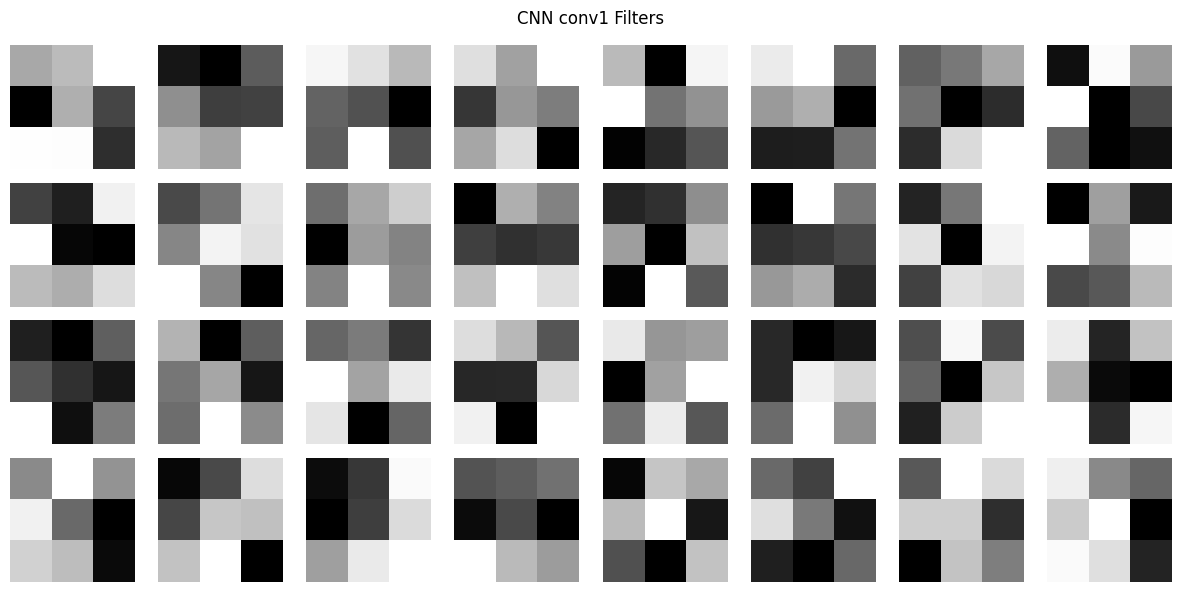

In [21]:
# Extract and visualize CNN filters
def visualize_cnn_filters(model, layer_name='conv1'):
    """Visualize CNN filters"""
    if layer_name == 'conv1':
        filters = model.conv1.weight.data.cpu().numpy()
    elif layer_name == 'conv2':
        filters = model.conv2.weight.data.cpu().numpy()
    else:
        filters = model.conv3.weight.data.cpu().numpy()

    fig, axes = plt.subplots(4, 8, figsize=(12, 6))
    fig.suptitle(f'CNN {layer_name} Filters')

    for i in range(min(32, filters.shape[0])):
        ax = axes[i//8, i%8]
        # Take first channel for visualization
        filter_img = filters[i, 0] if filters.shape[1] > 1 else filters[i]
        ax.imshow(filter_img, cmap='gray')
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# Visualize CNN filters
visualize_cnn_filters(cnn_model, 'conv1')

In [22]:
class OcclusionXAI_Working:
    def __init__(self, model, patch_size=56, stride=28):  # Much larger patches
        self.model = model
        self.patch_size = patch_size
        self.stride = stride

    def generate_attribution_map(self, image, target_class):
        self.model.eval()

        # Get original prediction (use logits for higher sensitivity)
        with torch.no_grad():
            original_output = self.model(image.unsqueeze(0).to(device))
            original_logit = original_output[0, target_class].item()

        c, h, w = image.shape
        attribution_map = np.zeros((h, w))

        print(f"Original logit: {original_logit:.6f}")

        patch_count = 0
        for y in range(0, h - self.patch_size + 1, self.stride):
            for x in range(0, w - self.patch_size + 1, self.stride):
                # Create occluded image with NOISE instead of zeros
                occluded_image = image.clone()
                noise = torch.randn_like(occluded_image[:, y:y+self.patch_size, x:x+self.patch_size]) * 0.5
                occluded_image[:, y:y+self.patch_size, x:x+self.patch_size] = noise

                with torch.no_grad():
                    occluded_output = self.model(occluded_image.unsqueeze(0).to(device))
                    occluded_logit = occluded_output[0, target_class].item()

                importance = original_logit - occluded_logit
                attribution_map[y:y+self.patch_size, x:x+self.patch_size] = importance

                print(f"Patch {patch_count}: logit change = {importance:.6f}")
                patch_count += 1

        return attribution_map
print("Testing with larger patches and noise occlusion:")
custom_occlusion = OcclusionXAI_Working(cnn_model, patch_size=56, stride=28)

Testing with larger patches and noise occlusion:


In [23]:
# Get a test sample
test_image, test_label = test_dataset[0]
test_image_tensor = test_image.unsqueeze(0).to(device)

# Get model prediction
with torch.no_grad():
    prediction = cnn_model(test_image_tensor)
    predicted_class = prediction.argmax(1).item()
    confidence = torch.softmax(prediction, dim=1).max().item()

print(f'True label: {test_label}, Predicted: {predicted_class}, Confidence: {confidence:.4f}')

# Generate attribution map using custom implementation
print("Generating attribution map with custom occlusion...")
custom_attribution = custom_occlusion.generate_attribution_map(test_image, predicted_class)

# Generate attribution map using Captum
print("Generating attribution map with Captum...")
captum_occlusion = Occlusion(cnn_model)
captum_attribution = captum_occlusion.attribute(
    test_image_tensor,
    target=predicted_class,
    sliding_window_shapes=(3, 16, 16),
    strides=(3, 8, 8)
)
captum_attribution = captum_attribution.squeeze().cpu().numpy().mean(axis=0)

True label: 0, Predicted: 0, Confidence: 1.0000
Generating attribution map with custom occlusion...
Original logit: 19.474857
Patch 0: logit change = -3.886248
Patch 1: logit change = -4.256298
Patch 2: logit change = -3.392021
Patch 3: logit change = -3.169649
Patch 4: logit change = -4.154352
Patch 5: logit change = -8.209679
Patch 6: logit change = -5.657309
Patch 7: logit change = -5.904636
Patch 8: logit change = -4.423384
Patch 9: logit change = -4.451206
Patch 10: logit change = -3.380480
Patch 11: logit change = -3.925976
Patch 12: logit change = -6.746782
Patch 13: logit change = -5.448200
Patch 14: logit change = -6.605967
Patch 15: logit change = -6.567862
Patch 16: logit change = -5.739048
Patch 17: logit change = -5.362909
Patch 18: logit change = -5.945183
Patch 19: logit change = -7.010515
Patch 20: logit change = -5.187250
Patch 21: logit change = -4.766314
Patch 22: logit change = -6.307390
Patch 23: logit change = -5.544004
Patch 24: logit change = -4.688694
Patch 25:

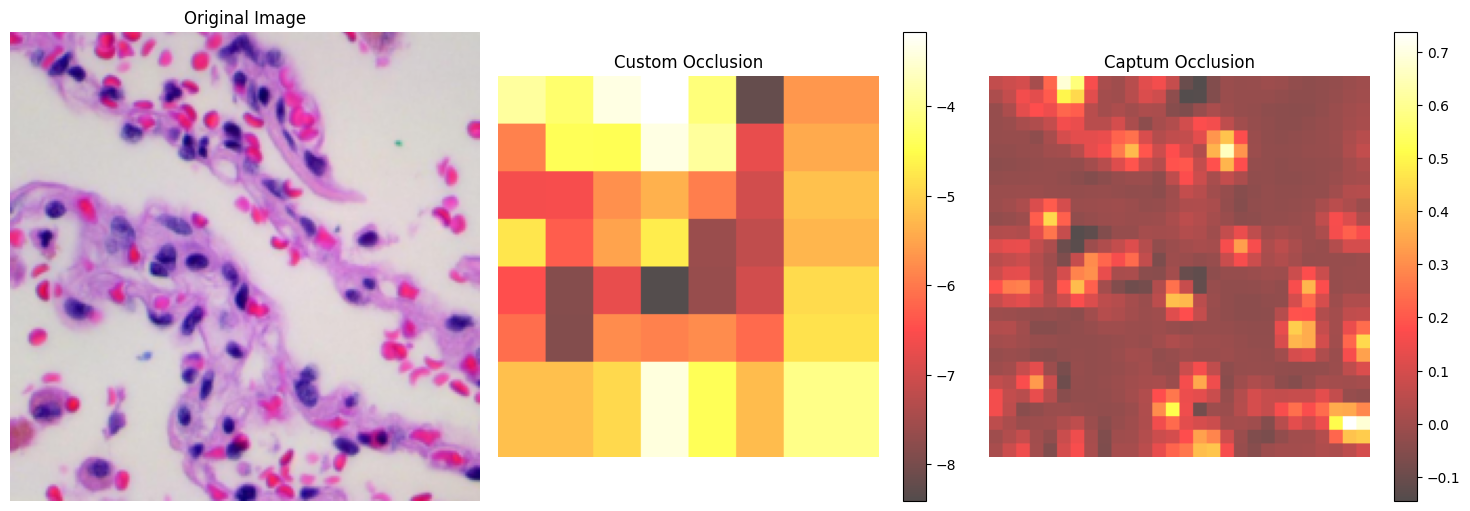

In [24]:
# Visualize results

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Original image
original_img = test_image.permute(1, 2, 0).cpu().numpy()
original_img = (original_img * np.array([0.229, 0.224, 0.225])) + np.array([0.485, 0.456, 0.406])
original_img = np.clip(original_img, 0, 1)
axes[0].imshow(original_img)
axes[0].set_title('Original Image')
axes[0].axis('off')

# Custom occlusion
im1 = axes[1].imshow(custom_attribution, cmap='hot', alpha=0.7)
axes[1].set_title('Custom Occlusion')
axes[1].axis('off')
plt.colorbar(im1, ax=axes[1])

# Captum occlusion
im2 = axes[2].imshow(captum_attribution, cmap='hot', alpha=0.7)
axes[2].set_title('Captum Occlusion')
axes[2].axis('off')
plt.colorbar(im2, ax=axes[2])

plt.tight_layout()
plt.show()


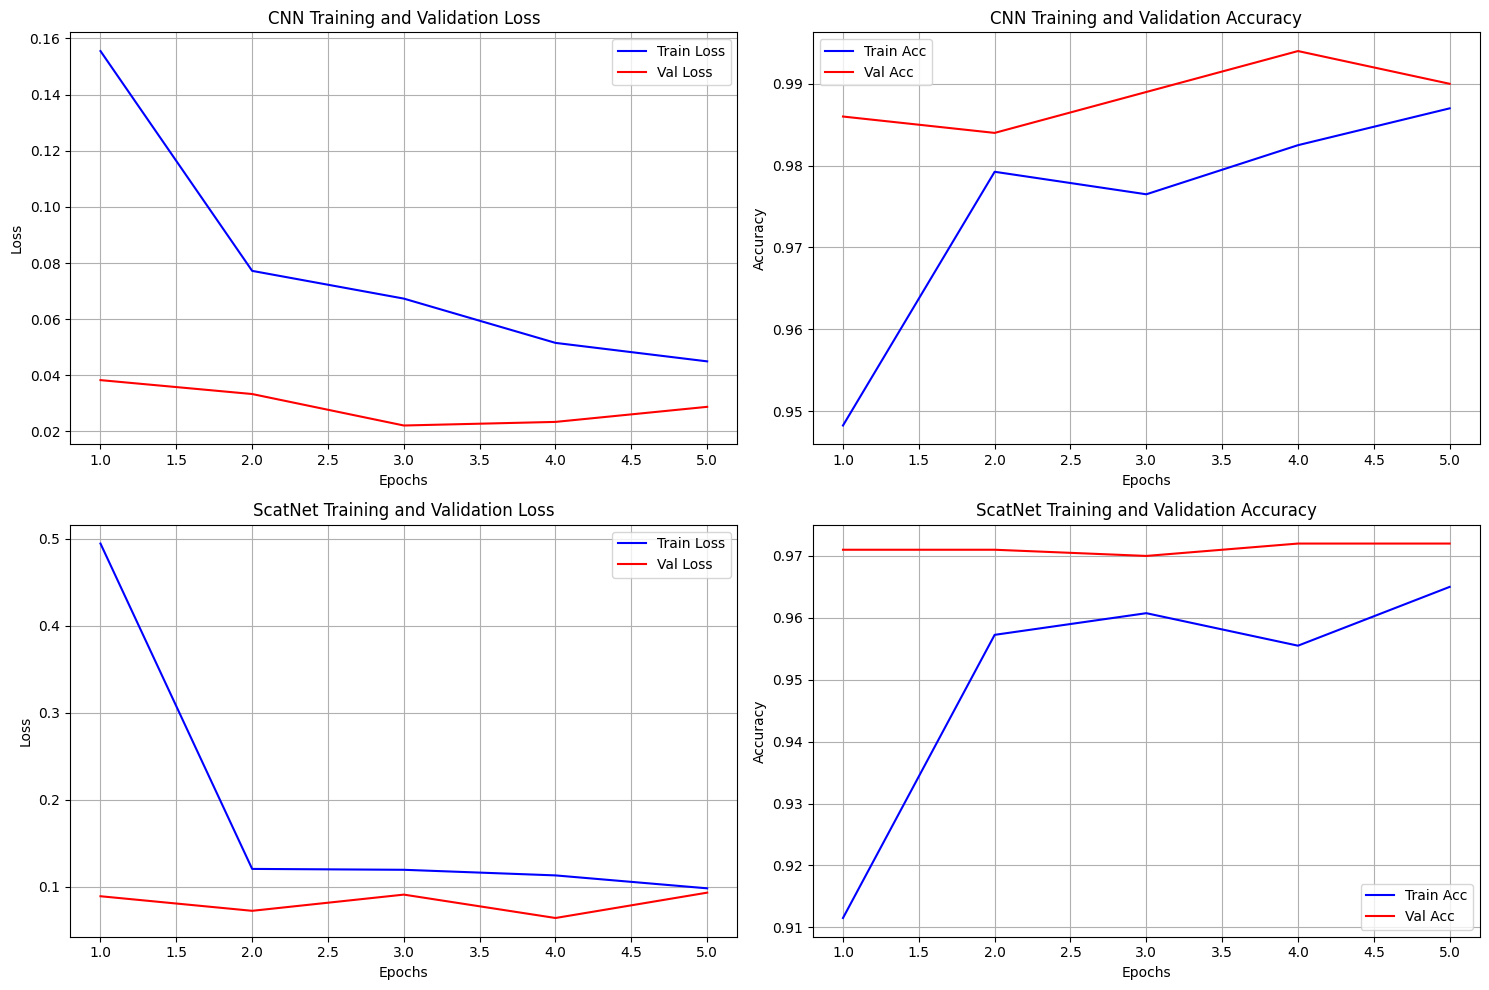

In [25]:
# Results visualization
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

epochs_range = range(1, 6)
ax1.plot(epochs_range, cnn_history['train_losses'], 'b-', label='Train Loss')
ax1.plot(epochs_range, cnn_history['val_losses'], 'r-', label='Val Loss')
ax1.set_title('CNN Training and Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)

ax2.plot(epochs_range, cnn_history['train_accs'], 'b-', label='Train Acc')
ax2.plot(epochs_range, cnn_history['val_accs'], 'r-', label='Val Acc')
ax2.set_title('CNN Training and Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.grid(True)

ax3.plot(epochs_range, scatnet_history['train_losses'], 'b-', label='Train Loss')
ax3.plot(epochs_range, scatnet_history['val_losses'], 'r-', label='Val Loss')
ax3.set_title('ScatNet Training and Validation Loss')
ax3.set_xlabel('Epochs')
ax3.set_ylabel('Loss')
ax3.legend()
ax3.grid(True)

ax4.plot(epochs_range, scatnet_history['train_accs'], 'b-', label='Train Acc')
ax4.plot(epochs_range, scatnet_history['val_accs'], 'r-', label='Val Acc')
ax4.set_title('ScatNet Training and Validation Accuracy')
ax4.set_xlabel('Epochs')
ax4.set_ylabel('Accuracy')
ax4.legend()
ax4.grid(True)

plt.tight_layout()
plt.show()

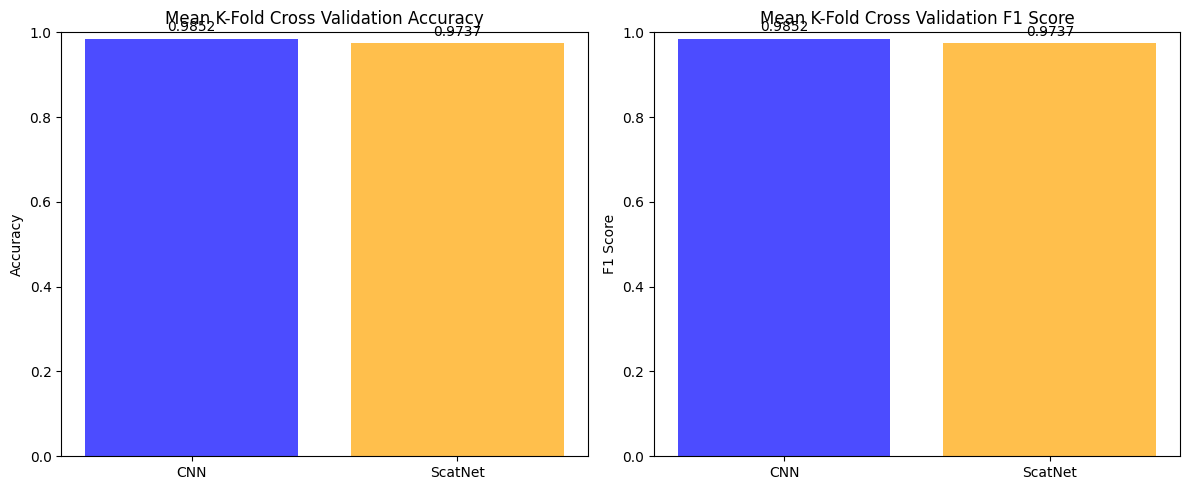

In [26]:
# Model comparison
models = ['CNN', 'ScatNet']
accuracies = [cnn_mean_acc, scatnet_mean_acc]
f1_scores = [cnn_mean_f1, scatnet_mean_f1]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

bars1 = ax1.bar(models, accuracies, color=['blue', 'orange'], alpha=0.7)
ax1.set_title('Mean K-Fold Cross Validation Accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_ylim(0, 1)
for i, v in enumerate(accuracies):
    ax1.text(i, v + 0.01, f'{v:.4f}', ha='center', va='bottom')

bars2 = ax2.bar(models, f1_scores, color=['blue', 'orange'], alpha=0.7)
ax2.set_title('Mean K-Fold Cross Validation F1 Score')
ax2.set_ylabel('F1 Score')
ax2.set_ylim(0, 1)
for i, v in enumerate(f1_scores):
    ax2.text(i, v + 0.01, f'{v:.4f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

Test Set Results:
CNN - Accuracy: 0.9900, F1: 0.9900
ScatNet - Accuracy: 0.9720, F1: 0.9720


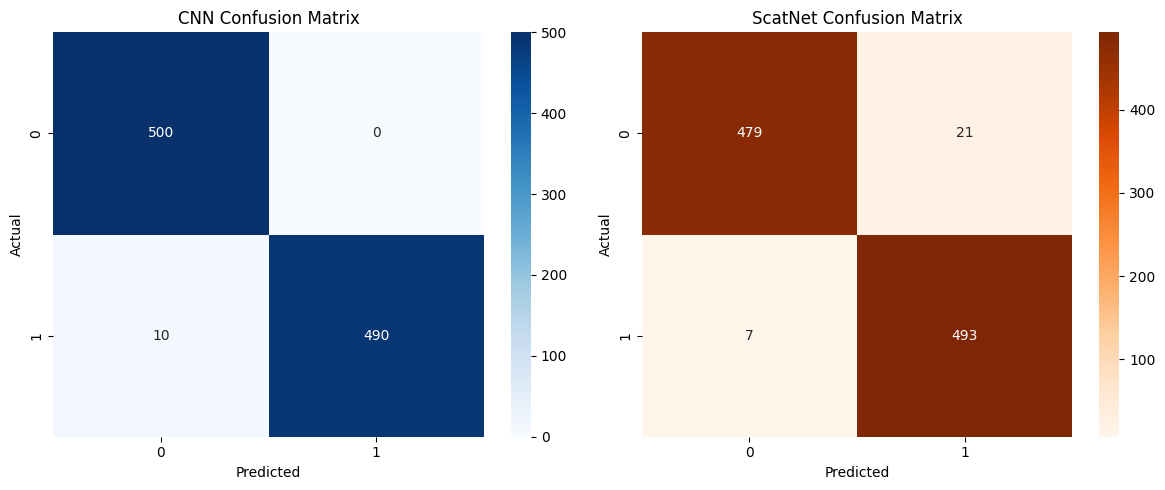

In [27]:
# Final test evaluation
cnn_preds, test_labels = evaluate_model(cnn_model, test_loader)
scatnet_preds, _ = evaluate_model(scatnet_model, test_loader)

cnn_test_acc = accuracy_score(test_labels, cnn_preds)
cnn_test_f1 = f1_score(test_labels, cnn_preds, average='weighted')

scatnet_test_acc = accuracy_score(test_labels, scatnet_preds)
scatnet_test_f1 = f1_score(test_labels, scatnet_preds, average='weighted')

print("Test Set Results:")
print(f"CNN - Accuracy: {cnn_test_acc:.4f}, F1: {cnn_test_f1:.4f}")
print(f"ScatNet - Accuracy: {scatnet_test_acc:.4f}, F1: {scatnet_test_f1:.4f}")

# Confusion matrices
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

cm_cnn = confusion_matrix(test_labels, cnn_preds)
sns.heatmap(cm_cnn, annot=True, fmt='d', cmap='Blues', ax=ax1)
ax1.set_title('CNN Confusion Matrix')
ax1.set_xlabel('Predicted')
ax1.set_ylabel('Actual')

cm_scatnet = confusion_matrix(test_labels, scatnet_preds)
sns.heatmap(cm_scatnet, annot=True, fmt='d', cmap='Oranges', ax=ax2)
ax2.set_title('ScatNet Confusion Matrix')
ax2.set_xlabel('Predicted')
ax2.set_ylabel('Actual')

plt.tight_layout()
plt.show()

In [28]:
# Summary
print("=" * 60)
print("LUNG CANCER CLASSIFICATION RESULTS SUMMARY")
print("=" * 60)
print(f"Dataset: Adenocarcinoma vs Benign (Binary Classification)")
print(f"Total samples: {len(image_paths)}")
print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")
print()

print("K-FOLD CROSS VALIDATION RESULTS (k=3):")
print("-" * 40)
print(f"CNN:")
print(f"  Mean Accuracy: {cnn_mean_acc:.4f} ± {np.std(cnn_fold_accs):.4f}")
print(f"  Mean F1 Score: {cnn_mean_f1:.4f} ± {np.std(cnn_fold_f1s):.4f}")
print()
print(f"ScatNet:")
print(f"  Mean Accuracy: {scatnet_mean_acc:.4f} ± {np.std(scatnet_fold_accs):.4f}")
print(f"  Mean F1 Score: {scatnet_mean_f1:.4f} ± {np.std(scatnet_fold_f1s):.4f}")
print()

print("TEST SET RESULTS:")
print("-" * 40)
print(f"CNN:")
print(f"  Test Accuracy: {cnn_test_acc:.4f}")
print(f"  Test F1 Score: {cnn_test_f1:.4f}")
print()
print(f"ScatNet:")
print(f"  Test Accuracy: {scatnet_test_acc:.4f}")
print(f"  Test F1 Score: {scatnet_test_f1:.4f}")
print()

print("XAI ANALYSIS:")
print("-" * 40)
print("✓ Custom Occlusion implementation completed")
print("✓ Captum Occlusion comparison completed")
print("✓ Attribution maps generated and visualized")
print()

print("MODEL ANALYSIS:")
print("-" * 40)
print("✓ CNN filters extracted and visualized")
print("✓ Both models use identical classifier architecture")
print("✓ Learning curves plotted for comparison")
print("✓ Confusion matrices generated")
print("=" * 60)

LUNG CANCER CLASSIFICATION RESULTS SUMMARY
Dataset: Adenocarcinoma vs Benign (Binary Classification)
Total samples: 5000
Training samples: 4000
Test samples: 1000

K-FOLD CROSS VALIDATION RESULTS (k=3):
----------------------------------------
CNN:
  Mean Accuracy: 0.9852 ± 0.0080
  Mean F1 Score: 0.9852 ± 0.0080

ScatNet:
  Mean Accuracy: 0.9737 ± 0.0040
  Mean F1 Score: 0.9737 ± 0.0040

TEST SET RESULTS:
----------------------------------------
CNN:
  Test Accuracy: 0.9900
  Test F1 Score: 0.9900

ScatNet:
  Test Accuracy: 0.9720
  Test F1 Score: 0.9720

XAI ANALYSIS:
----------------------------------------
✓ Custom Occlusion implementation completed
✓ Captum Occlusion comparison completed
✓ Attribution maps generated and visualized

MODEL ANALYSIS:
----------------------------------------
✓ CNN filters extracted and visualized
✓ Both models use identical classifier architecture
✓ Learning curves plotted for comparison
✓ Confusion matrices generated
